<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/SMOTE-NearMiss%20with%20Hybrid%20RF-LSTM%20(100%20ep_dropout%3D0.1%26l2%3D0.00001)%205%20classes%20(04052024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SMOTE-MissNear Hybrid RF-LSTM for 5 class classifications with k-folds, kernel=0.0001, Dropout=0.2(100ep)**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

In [2]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv")
dataset.isnull().sum()

 id                 0
 Time               0
 Is_CH              0
 who CH             0
 Dist_To_CH         0
 ADV_S              0
 ADV_R              0
 JOIN_S             0
 JOIN_R             0
 SCH_S              0
 SCH_R              0
Rank                0
 DATA_S             0
 DATA_R             0
 Data_Sent_To_BS    0
 dist_CH_To_BS      0
 send_code          0
Expaned Energy      0
Class               0
dtype: int64

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374661 entries, 0 to 374660
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0    id               374661 non-null  int64  
 1    Time             374661 non-null  int64  
 2    Is_CH            374661 non-null  int64  
 3    who CH           374661 non-null  int64  
 4    Dist_To_CH       374661 non-null  float64
 5    ADV_S            374661 non-null  int64  
 6    ADV_R            374661 non-null  int64  
 7    JOIN_S           374661 non-null  int64  
 8    JOIN_R           374661 non-null  int64  
 9    SCH_S            374661 non-null  int64  
 10   SCH_R            374661 non-null  int64  
 11  Rank              374661 non-null  int64  
 12   DATA_S           374661 non-null  int64  
 13   DATA_R           374661 non-null  int64  
 14   Data_Sent_To_BS  374661 non-null  int64  
 15   dist_CH_To_BS    374661 non-null  float64
 16   send_code        37

In [4]:
print(dataset["Class"].unique())

[0 4 3 1 2]


In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.utils import np_utils

encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=5)  # update to 5 classes
X = dataset.drop(['Class'], axis=1)
X = X.values
print(X.shape)
print(y.shape)

(374661, 18)
(374661, 5)


In [6]:
# Data preprocessing
y = dataset['Class'].values
X = dataset.drop(['Class'],axis=1)
X=X.values
print(X)
print(y)

[[1.0100000e+05 5.0000000e+01 1.0000000e+00 ... 1.3008535e+02
  0.0000000e+00 2.4694000e+00]
 [1.0100100e+05 5.0000000e+01 0.0000000e+00 ... 0.0000000e+00
  4.0000000e+00 6.9570000e-02]
 [1.0100200e+05 5.0000000e+01 0.0000000e+00 ... 0.0000000e+00
  3.0000000e+00 6.8980000e-02]
 ...
 [2.0109800e+05 1.0030000e+03 0.0000000e+00 ... 1.3926438e+02
  1.0000000e+00 9.4370000e-02]
 [2.0109900e+05 1.0030000e+03 0.0000000e+00 ... 1.5827492e+02
  3.0000000e+00 1.6047000e-01]
 [2.0204100e+05 1.0250000e+03 0.0000000e+00 ... 1.1500407e+02
  0.0000000e+00 1.0132500e+00]]
[0 0 0 ... 0 0 0]


In [7]:
import collections as c
counter = c.Counter(y)
print(counter)

Counter({0: 340066, 1: 14596, 2: 10049, 3: 6638, 4: 3312})


**SMOTE-NearMiss Databalancing**

In [8]:
# Check class distribution
counter = Counter(y)
print("Before SMOTE:", counter)

Before SMOTE: Counter({0: 340066, 1: 14596, 2: 10049, 3: 6638, 4: 3312})


In [9]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = c.Counter(y)
print(counter)

Counter({0: 340066, 4: 340066, 3: 340066, 1: 340066, 2: 340066})


In [10]:
# Apply NearMiss for undersampling
nm = NearMiss()
X_res, y_res = nm.fit_resample(X, y)
print("After NearMiss:", Counter(y_res))

After NearMiss: Counter({0: 340066, 1: 340066, 2: 340066, 3: 340066, 4: 340066})


**Data Splitting (Train 80/Test 20)**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**Utilized K-Fold Cross Validation**

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold
# Define the number of classes
num_classes = 5

# Define the number of folds
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [13]:
# Initialize lists to store evaluation metrics for each fold
accuracies = []
recalls = []
precisions = []
f1scores = []
confusion_matrices = []
classification_reports = []

In [14]:
# Iterate through the folds
#for fold, (train_index, test_index) in enumerate(skf.split(X, y.argmax(axis=1))):
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

**Hybrid RF-LSTM for 4 class Ver.2.2**

In [15]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.regularizers import l2
import numpy as np

# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Extract features from RF model
train_rf_features = rf_model.predict(X_train)
test_rf_features = rf_model.predict(X_test)

# Reshape RF features for LSTM input
#train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, train_rf_features.shape[1]))
#test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, test_rf_features.shape[1]))
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, 1))
test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, 1))

In [ ]:
train_rf_features = train_rf_features[:y_train.shape[0]]
#y_train = np.concatenate((y_train, np.zeros((train_rf_features.shape[0] - y_train.shape[0], 4))))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Train LSTM model with RF features
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, train_rf_features.shape[2]), return_sequences=True, kernel_regularizer=l2(0.00001)))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.00001)))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(16, kernel_regularizer=l2(0.00001)))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(5, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train = to_categorical(y_train, num_classes=5)  # One-hot encode y_train

history = lstm_model.fit(train_rf_features, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate hybrid model on test set
test_lstm_features = lstm_model.predict(test_rf_features)
test_rf_lstm_predictions = np.argmax(test_lstm_features, axis=1)

Epoch 1/100
19129/19129 [==============================] - 152s 8ms/step - loss: 0.0212 - accuracy: 0.9943 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 2/100
19129/19129 [==============================] - 139s 7ms/step - loss: 7.0206e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/100
19129/19129 [==============================] - 125s 7ms/step - loss: 5.5984e-04 - accuracy: 1.0000 - val_loss: 4.4970e-04 - val_accuracy: 1.0000
Epoch 4/100
19129/19129 [==============================] - 125s 7ms/step - loss: 5.2222e-04 - accuracy: 1.0000 - val_loss: 3.5730e-04 - val_accuracy: 1.0000
Epoch 5/100
19129/19129 [==============================] - 123s 6ms/step - loss: 5.2109e-04 - accuracy: 1.0000 - val_loss: 3.3448e-04 - val_accuracy: 1.0000
Epoch 6/100
19129/19129 [==============================] - 133s 7ms/step - loss: 5.0830e-04 - accuracy: 1.0000 - val_loss: 3.9582e-04 - val_accuracy: 1.0000
Epoch 7/100
19129/19129 [==============================] - 146s 8ms/st

Confusion Matrix:
[[33914    31     0    34    27]
 [    0 33997    10     0     0]
 [    0     3 34004     0     0]
 [   36     1     1 33968     0]
 [    1     0     0     0 34006]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34006
           1       1.00      1.00      1.00     34007
           2       1.00      1.00      1.00     34007
           3       1.00      1.00      1.00     34006
           4       1.00      1.00      1.00     34007

    accuracy                           1.00    170033
   macro avg       1.00      1.00      1.00    170033
weighted avg       1.00      1.00      1.00    170033



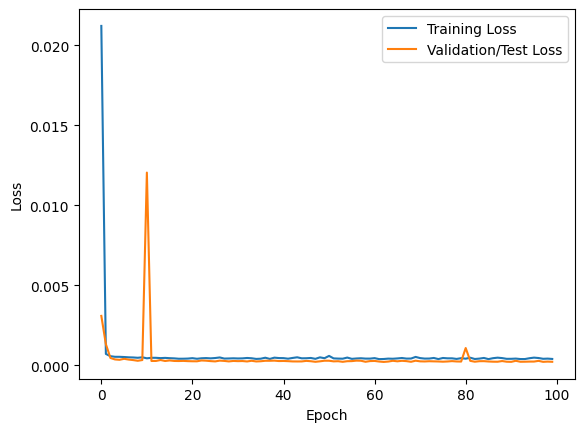

In [17]:
import collections as c

# Calculate the confusion matrix and classification report
# Ensure that y_test and test_rf_lstm_predictions are 2D arrays
confusion = confusion_matrix(y_test, test_rf_lstm_predictions)
classification_report_result = classification_report(y_test, test_rf_lstm_predictions)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_report_result)

# Plot the training and validation loss over each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_rf_lstm_predictions)
recall = recall_score(y_test, test_rf_lstm_predictions, average='weighted')
precision = precision_score(y_test, test_rf_lstm_predictions, average='weighted')
f1score = f1_score(y_test, test_rf_lstm_predictions, average='weighted')
confusion_mat = confusion_matrix(y_test, test_rf_lstm_predictions)
classification_rep = classification_report(y_test, test_rf_lstm_predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9991531055736239
Recall: 0.9991531055736239
Precision: 0.9991530172739338
F1-Score: 0.9991528710359094
Confusion Matrix:
 [[33914    31     0    34    27]
 [    0 33997    10     0     0]
 [    0     3 34004     0     0]
 [   36     1     1 33968     0]
 [    1     0     0     0 34006]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34006
           1       1.00      1.00      1.00     34007
           2       1.00      1.00      1.00     34007
           3       1.00      1.00      1.00     34006
           4       1.00      1.00      1.00     34007

    accuracy                           1.00    170033
   macro avg       1.00      1.00      1.00    170033
weighted avg       1.00      1.00      1.00    170033



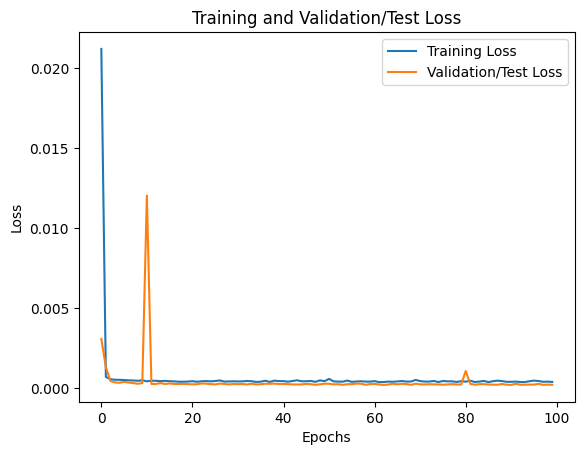

In [19]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

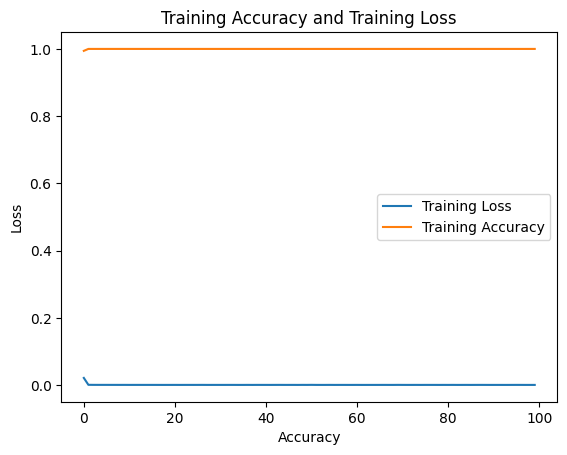

In [20]:
# Plot training loss and validation/test loss over each epoch of training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy and Training Loss')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


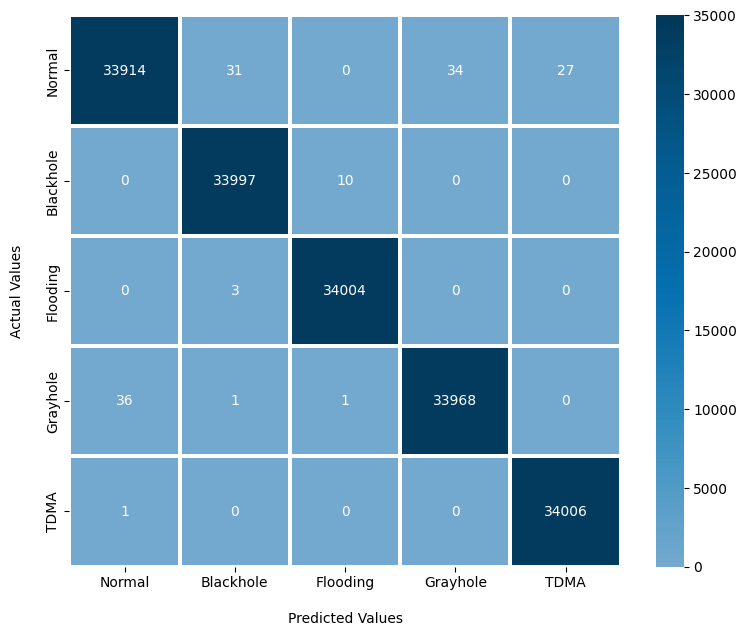

In [22]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
conf_mat(y_test, test_rf_lstm_predictions)

In [23]:
# Compute TP, TN, FP, FN for each class
cm = confusion_matrix(y_test, test_rf_lstm_predictions)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Compute False Positive Rate (FPR) and True Positive Rate (TPR) for each class
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

# Print FPR and TPR for each class
for i in range(5):
    print(f"Class {i} - FPR: {FPR[i]}, TPR: {TPR[i]}")

Class 0 - FPR: 0.00027200482257198937, TPR: 0.997294595071458
Class 1 - FPR: 0.00025730375075353243, TPR: 0.9997059428941101
Class 2 - FPR: 8.086689309396733e-05, TPR: 0.999911782868233
Class 3 - FPR: 0.00024995037749858483, TPR: 0.9988825501382109
Class 4 - FPR: 0.0001984914648670107, TPR: 0.999970594289411


In [24]:
# prompt: Show the detection rates of the model in 8 digits numerical

# Calculate detection rates and format them to 8 digits
detection_rates = TP / (TP + FN)
detection_rates_formatted = ["{:.10f}".format(rate) for rate in detection_rates]

# Print detection rates
for i, rate in enumerate(detection_rates_formatted):
    print(f"Class {i} Detection Rate: {rate}")

Class 0 Detection Rate: 0.9972945951
Class 1 Detection Rate: 0.9997059429
Class 2 Detection Rate: 0.9999117829
Class 3 Detection Rate: 0.9988825501
Class 4 Detection Rate: 0.9999705943


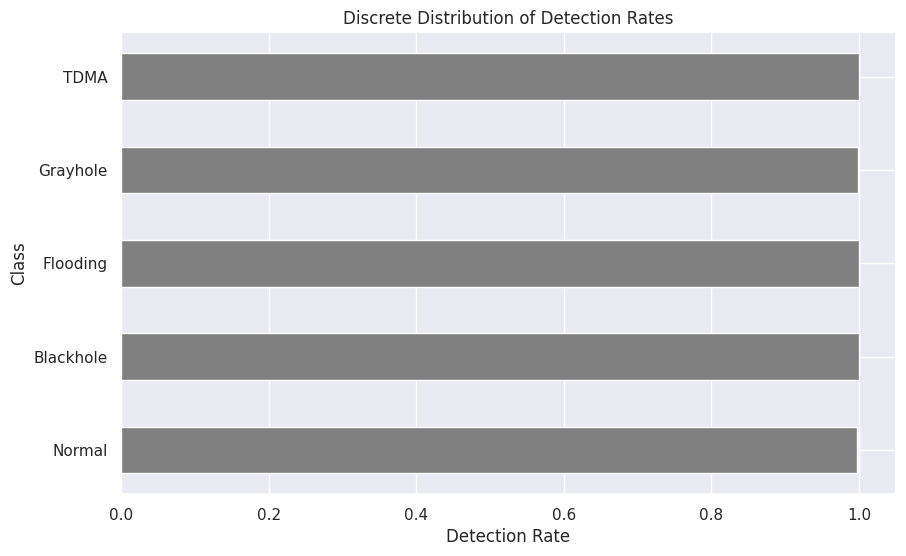

In [25]:
# prompt: Create Discrete distribution as horizontal bar chart of the detection rates of class 0-3

import numpy as np
import matplotlib.pyplot as plt

# Create a list of class labels
class_labels = ['Normal','Blackhole','Flooding','Grayhole','TDMA']

# Create a list of detection rates
detection_rates = [0.9972945951, 0.9997059429, 0.9999117829, 0.9988825501, 0.9999705943]

# Set the bar width
bar_width = 0.5

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(class_labels, detection_rates, bar_width, align='center', color='grey')

# Set the axis labels and title
plt.xlabel('Detection Rate')
plt.ylabel('Class')
plt.title('Discrete Distribution of Detection Rates')

# Display the chart
plt.show()

5314/5314 [==============================] - 11s 2ms/step


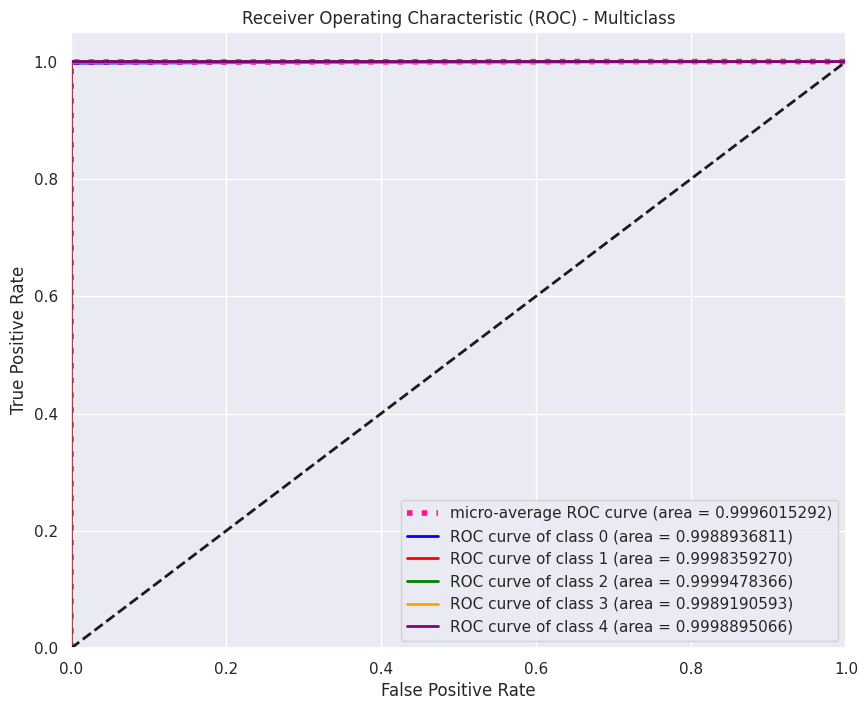

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming that y_test is not one-hot encoded
# Binarize the output labels for each class
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Predict class probabilities for LSTM model
test_lstm_probs = lstm_model.predict(test_rf_features)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_lstm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), test_lstm_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.10f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.10f})'.format(i, roc_auc[i]))

# Plot chance level
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()